In [18]:
# These are the misc imports and not required for the modeling process.
# Used to check model score and run time.
from sklearn.metrics import multilabel_confusion_matrix
from os.path import isfile, join
from os import listdir
import time

# Imports for viewing the images and change
import matplotlib.pyplot as plt
import numpy as np
import cv2

# From Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import MobileNet # pretrained model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense

## Making sure we can read in our images

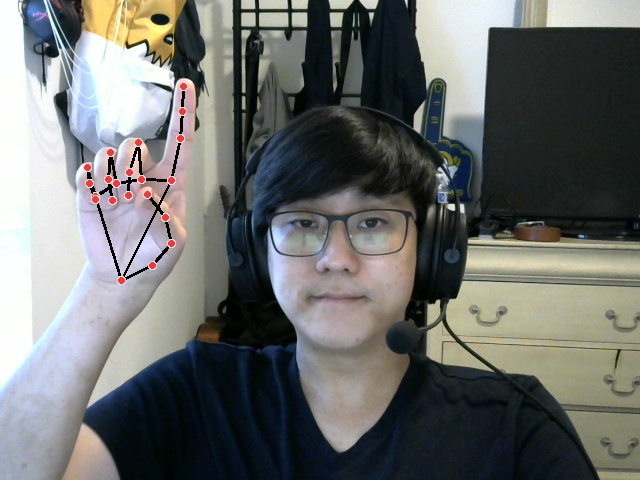

In [2]:
img_test = load_img('../imgs/train/volume_up/volume_up.56495766-41c0-11ec-8ed5-68545a69f685.jpg')
img_test

In [8]:
# Checking shape as well as first list of rgb colors
img_test_2 = cv2.imread('../imgs/train/volume_up/volume_up.56495766-41c0-11ec-8ed5-68545a69f685.jpg')
print(img_test_2.shape)
cv2.imread('../imgs/train/volume_up/volume_up.56495766-41c0-11ec-8ed5-68545a69f685.jpg')[0][:5]

(480, 640, 3)


array([[255, 255, 254],
       [255, 255, 254],
       [255, 255, 254],
       [255, 255, 254],
       [255, 255, 254]], dtype=uint8)

## Setting up the images in our folders 

#### Make get target names from the folders they were saved in as, and make sure pictures are all the same size

In [15]:
rescale = ImageDataGenerator(rescale=1/255, # scaling so everything will be from 0 - 1
                             # Next 4 lines will randomly choose images for data augmentation
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             brightness_range = (0.7, 1.3),
                             rotation_range = 20)

train_set = rescale.flow_from_directory('../imgs/train/',
                                    # MobileNet Excepts a square image, with 224 being the default
                                    target_size=(224, 224),
                                    class_mode='categorical',
                                    batch_size=16)

test_set = rescale.flow_from_directory('../imgs/test/',
                                   target_size=(224, 224),
                                   class_mode='categorical',
                                   batch_size= 16)

input_shape = train_set.image_shape
input_shape

Found 790 images belonging to 6 classes.
Found 144 images belonging to 6 classes.


(224, 224, 3)

## Check out 5 augmented Images

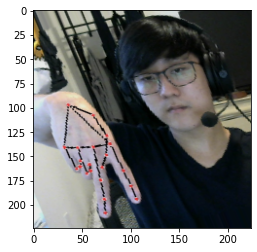

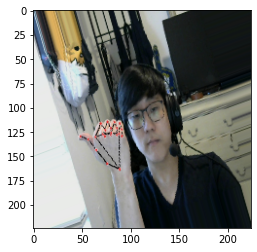

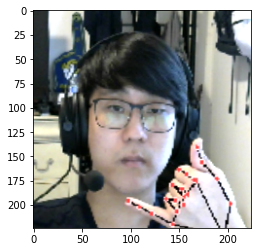

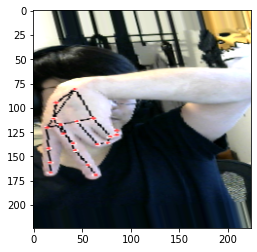

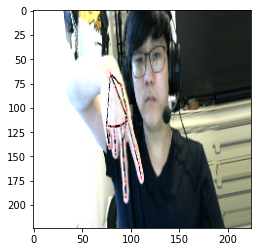

In [16]:
# Code from Noah Christiansen 
for _ in range(5):
    img, label = train_set.next()
    plt.imshow(img[0])
    plt.show()

## Checks

In [11]:
# Check the class indicies the imageDataGenerator just made
train_set.class_indices

{'forward': 0,
 'play_pause': 1,
 'rewind': 2,
 'screenshot': 3,
 'volume_down': 4,
 'volume_up': 5}

In [12]:
# lets make sure the order and names are the same for both train and test
test_set.class_indices

{'forward': 0,
 'play_pause': 1,
 'rewind': 2,
 'screenshot': 3,
 'volume_down': 4,
 'volume_up': 5}

In [17]:
# Getting the input shape of the image to pass into the model
input_shape = train_set.image_shape
input_shape

(224, 224, 3)

 ## MobileNet

In [102]:
mobile_net = MobileNet(include_top=False, input_shape = input_shape, pooling='avg')

In [94]:
mobile_net.trainable = False
model = Sequential()
model.add(mobile_net)
model.add(Dense(6, activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

# Step_size code from Noah Christiansen 
STEP_SIZE_TRAIN=train_set.n//train_set.batch_size
STEP_SIZE_VALID=test_set.n//test_set.batch_size

results = model.fit(train_set, epochs=10, verbose=1, validation_data=test_set, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
49/49 [==============================] - 17s 329ms/step - loss: 1.9480 - acc: 0.1684 - val_loss: 1.7679 - val_acc: 0.2431
Epoch 2/10
49/49 [==============================] - 15s 312ms/step - loss: 1.7579 - acc: 0.2584 - val_loss: 1.6268 - val_acc: 0.3264
Epoch 3/10
49/49 [==============================] - 15s 313ms/step - loss: 1.5950 - acc: 0.3540 - val_loss: 1.5102 - val_acc: 0.3958
Epoch 4/10
49/49 [==============================] - 15s 311ms/step - loss: 1.4374 - acc: 0.4638 - val_loss: 1.3489 - val_acc: 0.5000
Epoch 5/10
49/49 [==============================] - 15s 311ms/step - loss: 1.2770 - acc: 0.5581 - val_loss: 1.1886 - val_acc: 0.6042
Epoch 6/10
49/49 [==============================] - 15s 311ms/step - loss: 1.1813 - acc: 0.6305 - val_loss: 1.0776 - val_acc: 0.6944
Epoch 7/10
49/49 [==============================] - 15s 310ms/step - loss: 1.0908 - acc: 0.6783 - val_loss: 0.9904 - val_acc: 0.7431
Epoch 8/10
49/49 [==============================] - 15s 309ms/step - 

In [95]:
for layer in model.layers: 
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])
results = model.fit(train_set, epochs=15, verbose=1, validation_data=test_set, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID,
                    callbacks=[ModelCheckpoint('../models/mobilenet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')])

Epoch 1/15
49/49 [==============================] - ETA: 0s - loss: 0.3180 - acc: 0.9276
Epoch 00001: val_loss improved from inf to 0.15988, saving model to /content/drive/MyDrive/GA/Gesture Control/models/mobilenet.h5
49/49 [==============================] - 19s 339ms/step - loss: 0.3180 - acc: 0.9276 - val_loss: 0.1599 - val_acc: 0.9583
Epoch 2/15
49/49 [==============================] - ETA: 0s - loss: 0.0621 - acc: 0.9858
Epoch 00002: val_loss improved from 0.15988 to 0.05504, saving model to /content/drive/MyDrive/GA/Gesture Control/models/mobilenet.h5
49/49 [==============================] - 17s 339ms/step - loss: 0.0621 - acc: 0.9858 - val_loss: 0.0550 - val_acc: 0.9931
Epoch 3/15
49/49 [==============================] - ETA: 0s - loss: 0.0295 - acc: 0.9935
Epoch 00003: val_loss improved from 0.05504 to 0.03795, saving model to /content/drive/MyDrive/GA/Gesture Control/models/mobilenet.h5
49/49 [==============================] - 17s 342ms/step - loss: 0.0295 - acc: 0.9935 - val_

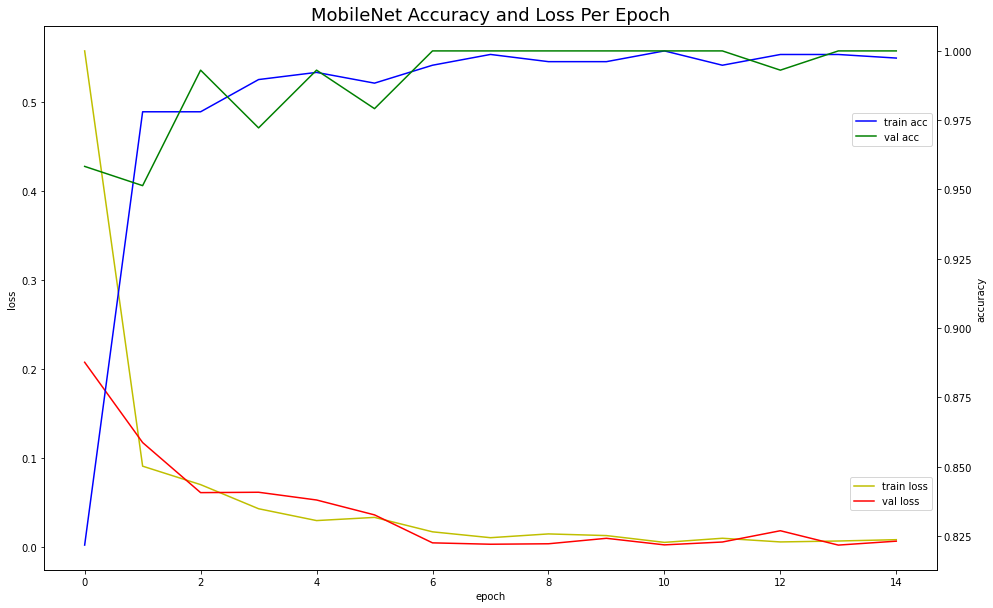

In [101]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc=4, bbox_to_anchor = (1,0.1))

acc_ax.plot(results.history['acc'], 'b', label='train acc')
acc_ax.plot(results.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 1, bbox_to_anchor = (1, 0.85))

plt.title('MobileNet Accuracy and Loss Per Epoch', size = 18)
plt.show()

> The `loss` and `val_loss` (on the left) goes down a fair ammount almost reaching 0  
> The `accuracy` and `val_accuracy` although different at the end, does have an intersection where both `accuracies` are at 1.00

## Load model to run tests

In [19]:
mn = load_model('../models/mobilenet.h5')

#### Checking with the test set and new images we have saved from notebook 1

In [20]:
rescale_no_aug = ImageDataGenerator(rescale=1/255)
test_set_square = rescale_no_aug.flow_from_directory('../imgs/test/',
                                   target_size=(224, 224),
                                   class_mode='categorical',
                                   batch_size= 1)

val_set_square = rescale_no_aug.flow_from_directory('../imgs/collected/test_set_folders/test_set/',
                                   target_size=(224, 224),
                                   class_mode='categorical',
                                   batch_size= 1)

Found 144 images belonging to 6 classes.
Found 15 images belonging to 6 classes.


#### Evaluate both of them, checking the time it takes as well as `accuracy` and `loss`

In [21]:
mn.evaluate(test_set_square)
mn.evaluate(val_set_square)

15/15 [==============================] - 0s 27ms/step - loss: 0.0178 - acc: 1.0000


[0.017832210287451744, 1.0]

#### Confusion Matrix for `test_set_square`

In [33]:
y_true = [test_set_square.classes[index] for index in test_set_square.index_array]
preds = np.argmax(mn.predict(test_set_square), axis = 1)

multilabel_confusion_matrix(y_true, preds)

array([[[120,   0],
        [  0,  24]],

       [[120,   0],
        [  0,  24]],

       [[120,   0],
        [  0,  24]],

       [[120,   0],
        [  0,  24]],

       [[120,   0],
        [  0,  24]],

       [[120,   0],
        [  0,  24]]], dtype=int64)

> For all 6 classes, every single one of them was predicted correctly with no false positive or false negative

#### Confusion Matrix for `val_set_square`

In [34]:
y_true = [val_set_square.classes[index] for index in val_set_square.index_array]
preds = np.argmax(mn.predict(val_set_square), axis = 1)

multilabel_confusion_matrix(y_true, preds)

array([[[12,  0],
        [ 0,  3]],

       [[12,  0],
        [ 0,  3]],

       [[13,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  2]],

       [[12,  0],
        [ 0,  3]]], dtype=int64)

> For all 6 classes, every single one of them was predicted correctly with no false positive or false negative

#### list of the actions to predict, ordered by class_indicies from imageDataGenerator

In [ ]:
actions = ['forward', 'play_pause', 'rewind', 'screenshot', 'volume_down', 'volume_up']

#### List comprehension to just get the names of the files in the test_set

In [35]:
files = [f for f in listdir('../imgs/collected/test_set') if isfile(join('../imgs/collected/test_set', f))]
files

['forward_1.jpg',
 'forward_2.jpg',
 'forward_3.jpg',
 'pp_1.jpg',
 'pp_2.jpg',
 'pp_3.jpg',
 'rewind_1.jpg',
 'rewind_2.jpg',
 'ss_1.jpg',
 'ss_2.jpg',
 'vol-down_1.jpg',
 'vol-down_2.jpg',
 'vol-up_1.jpg',
 'vol-up_2.jpg',
 'vol-up_3.jpg']

#### How to resize cv2 images found [here](https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/)
<img src = './notebook_imgs/how_to_resize.png' width = "500" >

This is for the MobileNet model
-------------------------------


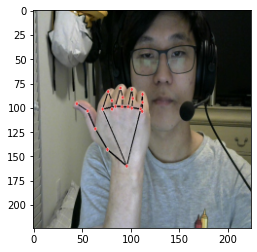

0.097 seconds to run
Picture is: forward
Prediction is: forward
Confidence: 0.9995170831680298
---------------------------------------------


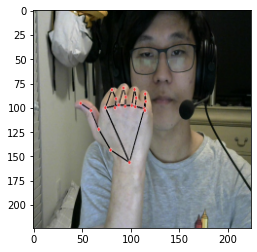

0.065 seconds to run
Picture is: forward
Prediction is: forward
Confidence: 0.9989919066429138
---------------------------------------------


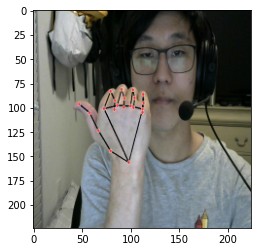

0.059 seconds to run
Picture is: forward
Prediction is: forward
Confidence: 0.9995664954185486
---------------------------------------------


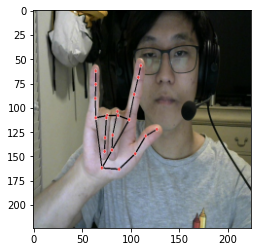

0.081 seconds to run
Picture is: pp
Prediction is: play_pause
Confidence: 0.9573161005973816
---------------------------------------------


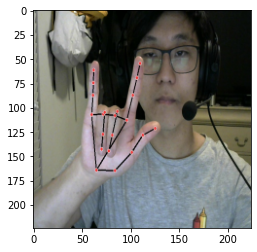

0.055 seconds to run
Picture is: pp
Prediction is: play_pause
Confidence: 0.966025710105896
---------------------------------------------


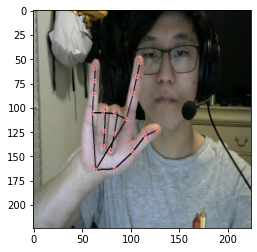

0.051 seconds to run
Picture is: pp
Prediction is: play_pause
Confidence: 0.9668229222297668
---------------------------------------------


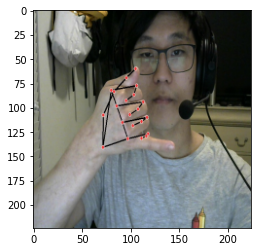

0.051 seconds to run
Picture is: rewind
Prediction is: rewind
Confidence: 0.9828155636787415
---------------------------------------------


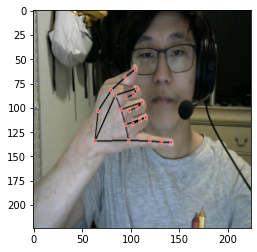

0.244 seconds to run
Picture is: rewind
Prediction is: rewind
Confidence: 0.9970105886459351
---------------------------------------------


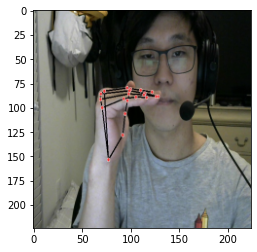

0.054 seconds to run
Picture is: ss
Prediction is: screenshot
Confidence: 0.9934548735618591
---------------------------------------------


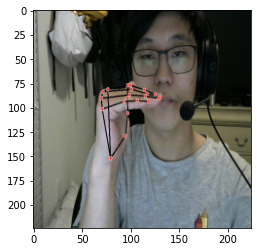

0.052 seconds to run
Picture is: ss
Prediction is: screenshot
Confidence: 0.9963395595550537
---------------------------------------------


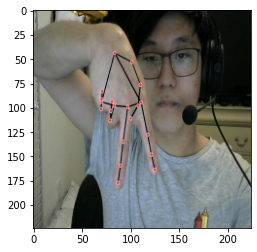

0.053 seconds to run
Picture is: vol-down
Prediction is: volume_down
Confidence: 0.9999445676803589
---------------------------------------------


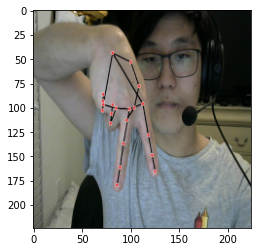

0.054 seconds to run
Picture is: vol-down
Prediction is: volume_down
Confidence: 0.9999047517776489
---------------------------------------------


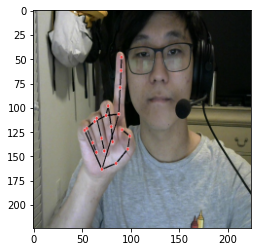

0.054 seconds to run
Picture is: vol-up
Prediction is: volume_up
Confidence: 0.9901723861694336
---------------------------------------------


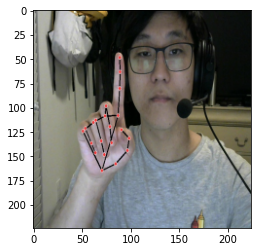

0.058 seconds to run
Picture is: vol-up
Prediction is: volume_up
Confidence: 0.9895167946815491
---------------------------------------------


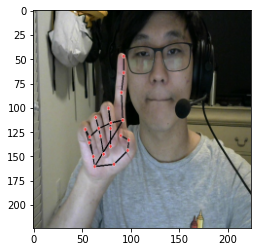

0.056 seconds to run
Picture is: vol-up
Prediction is: volume_up
Confidence: 0.9957774877548218
---------------------------------------------


In [36]:
print('This is for the MobileNet model')
print('-------------------------------')
for file in files:
    test = cv2.imread(f'../imgs/collected/test_set/{file}')
    test =  cv2.resize(test, (224,224), interpolation = cv2.INTER_AREA) # Adapted from image above
    image = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
    t0 = time.time()
    pred_prob = mn.predict(test.reshape(1, 224, 224, 3)/255)
    pred = actions[np.argmax(pred_prob)]
    print(f'{round(time.time() - t0,3)} seconds to run')
    print(f"Picture is: {file.split('_')[0]}\nPrediction is: {pred}")
    print(f'Confidence: {np.max(pred_prob)}')
    print('---'*15)

> Every Single image was correctly predicted and most of them were done in under 0.01 seconds, showing that this model is now ready for a webcam test